# Quantitative sampling of CheXpert dataset

## Import libraries

In [83]:
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

## Load meta-data

In [3]:
meta_data_base_path = os.path.join(os.environ.get('PROJECT_DATA_BASE_DIR'), 'CheXpert-v1.0-small/')
meta_data_train_path = os.path.join(meta_data_base_path, 'train.csv')
meta_data_test_path = os.path.join(meta_data_base_path, 'valid.csv')

meta_data_train_full = pd.read_csv(meta_data_train_path)
meta_data_train = meta_data_train_full.copy()

meta_data_train_full.columns = meta_data_train.columns.str.replace(' ', '_')

meta_data_test = pd.read_csv(meta_data_test_path)

In [4]:
print(f"Total train records: {len(meta_data_train)}")
meta_data_train.head()

Total train records: 223414


,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [5]:
print(f"Total test records: {len(meta_data_test)}")
meta_data_test.head()

Total test records: 234


,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/valid/patient64541/study1/...,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Lateral,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,CheXpert-v1.0-small/valid/patient64543/study1/...,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CheXpert-v1.0-small/valid/patient64544/study1/...,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Only include competition observations

In [6]:
for df in [meta_data_train, meta_data_test]:
    df.drop(
        ['No Finding', 'Enlarged Cardiomediastinum', 'Lung Opacity', 'Lung Lesion', 'Pneumonia', 'Pneumothorax', 'Pleural Other', 'Fracture', 'Support Devices'],
        axis=1, inplace=True
    )

### Re-label competition fields according to source code

In original training dataset: 
* Label of 1.0 indicates a positive observation.

* Label of 0.0 indicates there is atleast one negatively classified mention. 

* Label of -1.0 indicates uncertainty.

* Label of Nan indicates that there was no mention of an observation.


In augmentation:
* For Edema and Atelectasis:
    * Nan -> 0
    * -1.0 -> 0 (U-Zeroes)
* For Cardiomegaly, Consolidation and Pleural Effusion:
    * Nan -> 0
    * -1.0 -> 1 (U-Ones)

In [7]:
competition_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']
meta_data_train[competition_labels] = meta_data_train[competition_labels].fillna(0.0)

meta_data_train[['Edema','Atelectasis']] =\
    meta_data_train[['Edema','Atelectasis']].replace([-1.0], [0.0])

meta_data_train[['Cardiomegaly', 'Consolidation', 'Pleural Effusion']] =\
    meta_data_train[['Cardiomegaly', 'Consolidation', 'Pleural Effusion']].replace([-1.0], [1.0])

In [8]:
meta_data_train.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,Cardiomegaly,Edema,Consolidation,Atelectasis,Pleural Effusion
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,0.0,0.0,0.0,0.0,0.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,1.0,0.0,1.0,0.0,1.0
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,0.0,0.0,1.0,0.0,0.0
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,0.0,0.0,1.0,0.0,0.0
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,0.0,1.0,0.0,0.0,0.0


## Visualise Distributions between Train and Test folds

In [9]:
def plot_distributions(col, kind, data=[meta_data_train, meta_data_test], data_labels=['Train', 'Test'], bins=None):
    sns.set(style='darkgrid') 
    fig, axes = plt.subplots(nrows=1, ncols=2)
    for i, c_plot in enumerate(axes):
        if kind == 'count':
            total = float(len(data[i]))
            sns.countplot(x=f'{col}', data=data[i], order=sorted(data[i][f'{col}'].value_counts().index), ax=c_plot)
            for p in c_plot.patches:
                height = p.get_height()
                c_plot.text(p.get_x()+p.get_width()/2.,
                        height + 3,
                        '{:1.2f}'.format(height/total),
                        ha="center") 
        elif kind == 'hist':
            sns.distplot(data[i][f'{col}'], bins=bins, ax=c_plot)
        c_plot.set_title(f'Distribution in {data_labels[i]}')

    fig.tight_layout(pad=3.0)

#### Sex

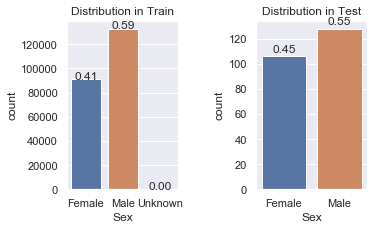

In [10]:
plot_distributions(col='Sex', kind='count')

#### Age

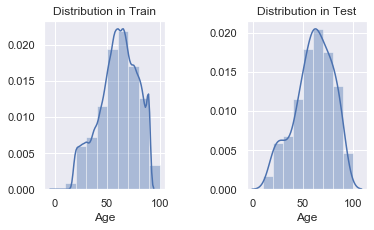

In [11]:
plot_distributions(col='Age', kind='hist', bins=[x * 10 for x in range(1, 11)])

#### Frontal/Lateral

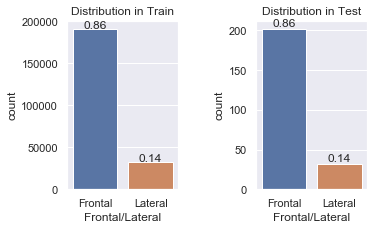

In [12]:
plot_distributions(col='Frontal/Lateral', kind='count')

#### AP/PA

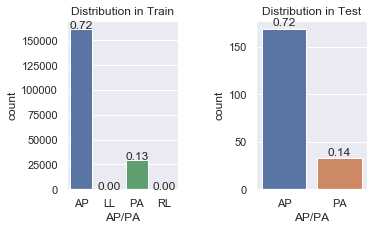

In [13]:
plot_distributions(col='AP/PA', kind='count')

#### All Observations

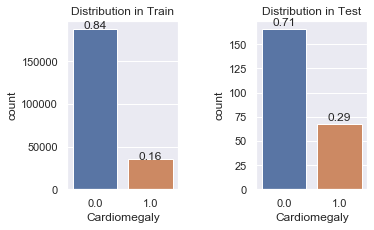

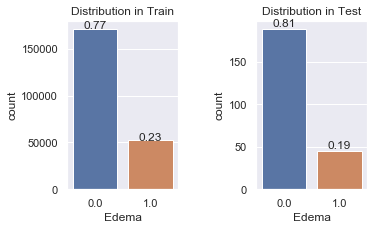

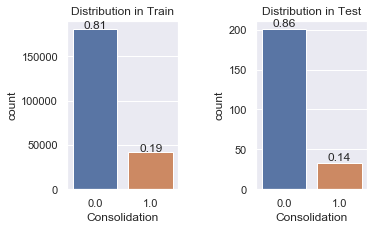

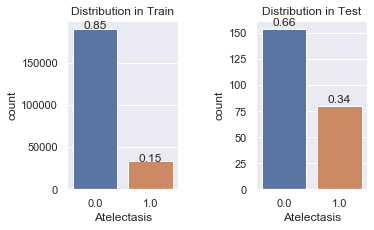

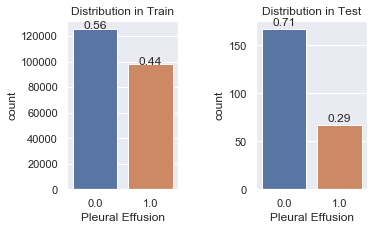

In [14]:
observation_cols = list(meta_data_train.columns[5:])

for col in observation_cols:
    plot_distributions(col=col, kind='count')

## Perform quantitative sampling for centralised model

In [15]:
X = meta_data_train[meta_data_train.columns[:5]]

In [16]:
y = meta_data_train[meta_data_train.columns[5:]]

In [17]:
X_train, _, y_train, _ = train_test_split(X, y, test_size=0.95, random_state=42, stratify=y)

In [18]:
meta_data_sample = pd.concat([X_train, y_train], axis=1)
print(f"Number of records in sample: {len(meta_data_sample)}")
meta_data_sample.head()

Number of records in sample: 11170


,Path,Sex,Age,Frontal/Lateral,AP/PA,Cardiomegaly,Edema,Consolidation,Atelectasis,Pleural Effusion
104908,CheXpert-v1.0-small/train/patient25190/study4/...,Female,77,Frontal,AP,0.0,0.0,0.0,0.0,1.0
68994,CheXpert-v1.0-small/train/patient16529/study1/...,Male,65,Frontal,AP,1.0,0.0,0.0,0.0,0.0
5382,CheXpert-v1.0-small/train/patient01338/study1/...,Male,64,Frontal,AP,0.0,0.0,0.0,0.0,0.0
128608,CheXpert-v1.0-small/train/patient30791/study2/...,Male,54,Lateral,NaN,0.0,0.0,1.0,0.0,1.0
13193,CheXpert-v1.0-small/train/patient03282/study11...,Male,30,Lateral,NaN,0.0,0.0,1.0,0.0,1.0


### Sanity check that the labels have been appropriately stratified

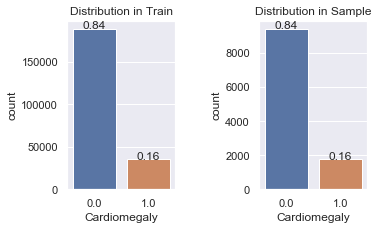

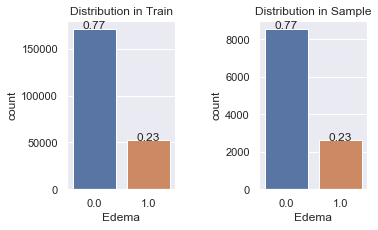

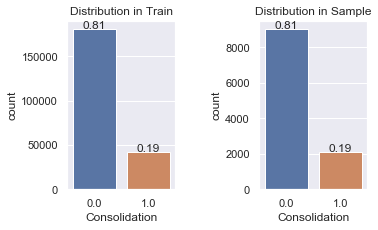

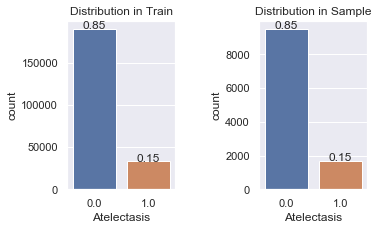

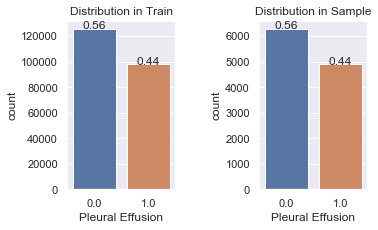

In [19]:
for col in observation_cols:
    plot_distributions(col=col, kind='count', data=[meta_data_train, meta_data_sample], data_labels=['Train', 'Sample'])

### Observe distribution in meta-data (non stratified features)

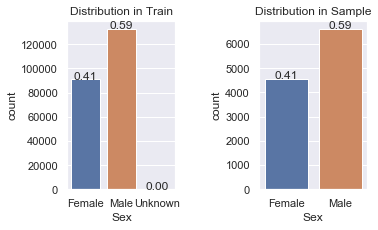

In [20]:
plot_distributions(col='Sex', kind='count', data=[meta_data_train, meta_data_sample], data_labels=['Train', 'Sample'])

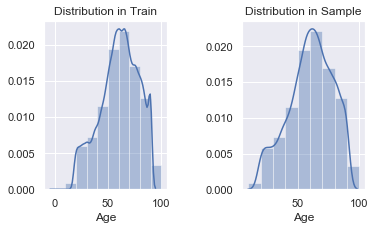

In [21]:
plot_distributions(col='Age', kind='hist', bins=[x * 10 for x in range(1, 11)], data=[meta_data_train, meta_data_sample], data_labels=['Train', 'Sample'])

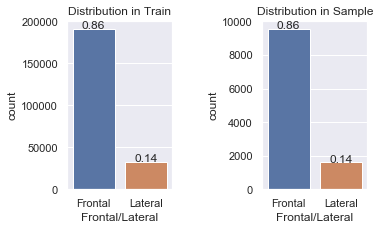

In [22]:
plot_distributions(col='Frontal/Lateral', kind='count', data=[meta_data_train, meta_data_sample], data_labels=['Train', 'Sample'])

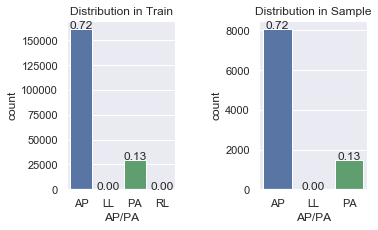

In [23]:
plot_distributions(col='AP/PA', kind='count', data=[meta_data_train, meta_data_sample], data_labels=['Train', 'Sample'])

## Generate corresponding train csv file

In [24]:
def generate_csv_file(filename, sample):
    sample_path_list = sample['Path'].tolist()
    sample_original = meta_data_train_full[meta_data_train_full['Path'].isin(sample_path_list)]
    
    # prepend absolute path
    path_prefix = os.environ.get('PROJECT_DATA_BASE_DIR') + '/'
    sample_original['Path'] = path_prefix + sample_original['Path'].astype(str)
    sample_original.to_csv(filename, index=False)
    
    return sample_original

In [25]:
central_sample = generate_csv_file('train_subset_5_percent.csv', meta_data_sample)

/vol/bitbucket/eb1816/individual_project/venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [28]:
central_sample.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No_Finding,Enlarged_Cardiomediastinum,Cardiomegaly,Lung_Opacity,Lung_Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture,Support_Devices
16,/vol/bitbucket/eb1816/individual_project/data/...,Male,76,Frontal,PA,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
36,/vol/bitbucket/eb1816/individual_project/data/...,Female,55,Frontal,PA,NaN,-1.0,-1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,1.0
45,/vol/bitbucket/eb1816/individual_project/data/...,Female,76,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,1.0,-1.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN
54,/vol/bitbucket/eb1816/individual_project/data/...,Female,50,Frontal,AP,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,0.0
75,/vol/bitbucket/eb1816/individual_project/data/...,Male,67,Lateral,NaN,NaN,NaN,1.0,1.0,NaN,0.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1.0


## Generate non-iid folds for institutions

In [137]:
# For reproducibility
np.random.seed(42)

weights = np.random.random_sample(size=len(meta_data_sample))
weights /= weights.sum()

### Generate 50/50 non-iid fold for institutions

In [138]:
A_50 = meta_data_sample.sample(frac=0.50, weights=weights, axis=0, random_state=42)
B_50 = meta_data_sample.drop(A_50.index)

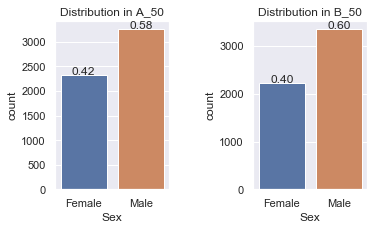

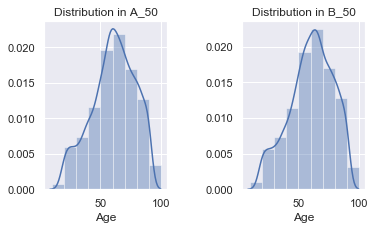

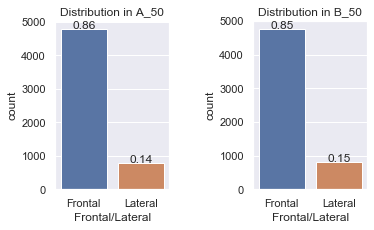

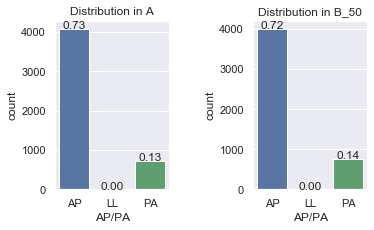

In [139]:
plot_distributions(col='Sex', kind='count', data=[A_50, B_50], data_labels=['A_50', 'B_50'])
plot_distributions(col='Age', kind='hist', data=[A_50, B_50], data_labels=['A_50', 'B_50'], bins=[x * 10 for x in range(1, 11)])
plot_distributions(col='Frontal/Lateral', kind='count', data=[A_50, B_50], data_labels=['A_50', 'B_50'])
plot_distributions(col='AP/PA', kind='count', data=[A_50, B_50], data_labels=['A', 'B_50'])

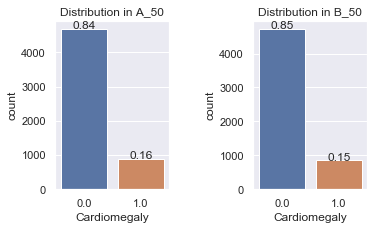

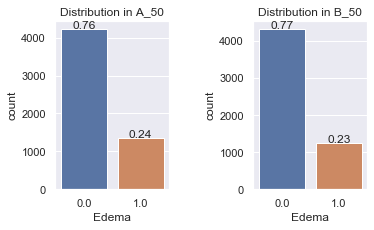

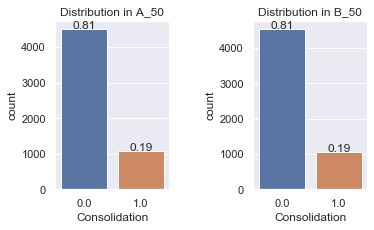

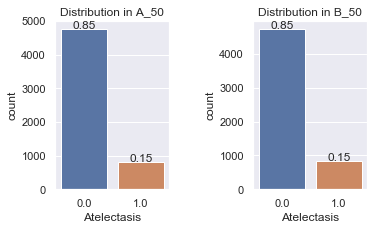

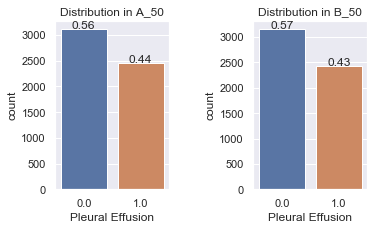

In [140]:
for col in observation_cols:
    plot_distributions(col=col, kind='count', data=[A_50, B_50], data_labels=['A_50', 'B_50'])

In [145]:
A_50_df = generate_csv_file('train_subset_5_percent_A_50.csv', A_50)
B_50_df = generate_csv_file('train_subset_5_percent_B_50.csv', B_50)

/vol/bitbucket/eb1816/individual_project/venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


### Generate 75/25 non-iid fold for institutions

In [141]:
A_75 = meta_data_sample.sample(frac=0.75, weights=weights, axis=0, random_state=42)
B_25 = meta_data_sample.drop(A_75.index)

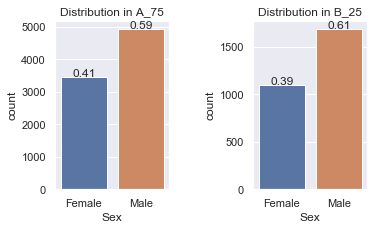

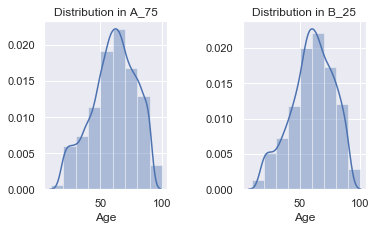

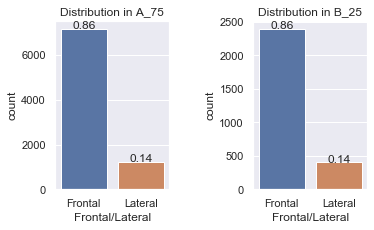

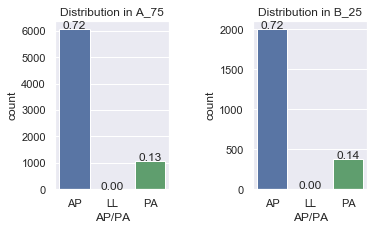

In [142]:
plot_distributions(col='Sex', kind='count', data=[A_75, B_25], data_labels=['A_75', 'B_25'])
plot_distributions(col='Age', kind='hist', data=[A_75, B_25], data_labels=['A_75', 'B_25'], bins=[x * 10 for x in range(1, 11)])
plot_distributions(col='Frontal/Lateral', kind='count', data=[A_75, B_25], data_labels=['A_75', 'B_25'])
plot_distributions(col='AP/PA', kind='count', data=[A_75, B_25], data_labels=['A_75', 'B_25'])

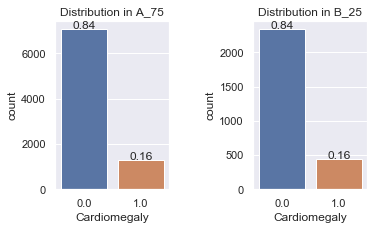

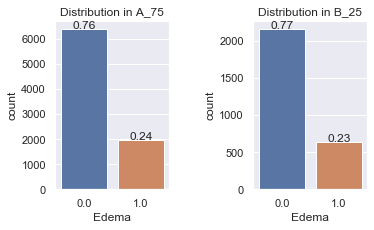

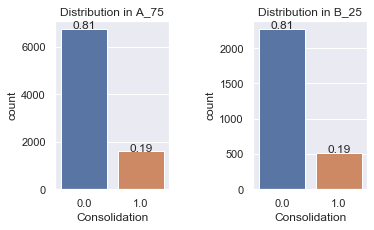

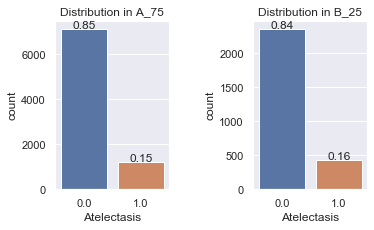

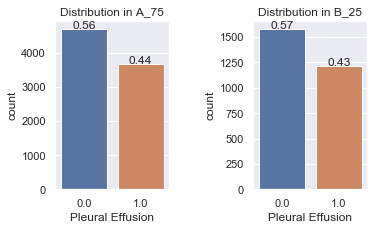

In [143]:
for col in observation_cols:
    plot_distributions(col=col, kind='count', data=[A_75, B_25], data_labels=['A_75', 'B_25'])

In [146]:
A_75_df = generate_csv_file('train_subset_5_percent_A_75.csv', A_75)
B_25_df = generate_csv_file('train_subset_5_percent_B_25.csv', B_25)

/vol/bitbucket/eb1816/individual_project/venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
